# Import Statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import math
import random
import timeit

from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error, mean_absolute_error

---

In [2]:
marburg = pd.read_pickle("../0_data/marburg_clean.pkl")
duisburg = pd.read_pickle('../0_data/duisburg_clean.pkl')
marburg_weather = pd.read_pickle("../0_data/weather/marburg_weather.pkl")
duisburg_weather = pd.read_pickle("../0_data/weather/duisburg_weather.pkl")

# Radial Basis Function

In [3]:
def rbf_feat(x, mu, sig):
    return np.hstack([np.exp(-(x[:,None] - mu)**2/(2*sig**2)), np.ones((len(x),1))])

In [4]:
def train_rbf(x, y, n_rbf, lam):
    min_x, max_x = x.min(), x.max()
    sig = (max_x - min_x)/(n_rbf-1)
    mu = np.linspace(min_x, max_x, n_rbf-1)
    
    Phi = rbf_feat(x, mu, sig)
    theta = np.linalg.solve(Phi.T @ Phi + lam*np.eye(Phi.shape[1]), Phi.T @ y)
    return theta, mu, sig

In [5]:
def plot_regression_rbf(theta, mu, sig):
    xt = np.linspace(0,365, 400)
    yt = rbf_feat(xt, mu, sig) @ theta
    
    plt.figure(figsize = (8,6))
    plt.scatter(xp, yp, marker="x")
    ylim = plt.ylim()
    plt.plot(xt, yt, 'C1')
    plt.xlabel("Day of year")
    plt.ylabel("Peak Demand")               

## Marburg

In [6]:
# peak demand
ma = pd.DataFrame(marburg.resample('H').count()["day"])
ma.rename(columns={'day': 'demand'}, inplace=True)

ma['dayofyear'] = ma.index.map(lambda datetime : datetime.dayofyear)
ma['week'] = ma.index.map(lambda datetime : datetime.week)
ma['weekday'] = ma.index.map(lambda datetime : datetime.weekday)
ma['is_weekday'] = ma['weekday'].map(lambda day : day < 5)
ma['hour'] = ma.index.map(lambda datetime : datetime.hour)

ma = ma.merge(marburg_weather, left_index=True, right_index=True)

In [7]:
X = ma[['temperature', 'hour', 'precipitation', 'dayofyear']].values
y = ma['demand'].values

# ma['weekday'] = ma['weekday'].astype('category')

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
# 50 train - 20 hold - 30 test

# Do a 70-30 split first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=34 )

# now split X_train to achive 50-20-30 split
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=(0.2/0.5),random_state=34 )

for name, data in {'train': X_train, 'validation': X_val, 'test': X_test}.items():
    print("""{}
    {} entries
    ~{:.2f}% of total data
    
    """.format(name, len(data), len(data)/len(X)))

train
    4392 entries
    ~0.50% of total data
    
    
validation
    1757 entries
    ~0.20% of total data
    
    
test
    2635 entries
    ~0.30% of total data
    
    


In [13]:
mean_absolute_error(rbf_ridge_model(1, 1).predict(X_val), y_val)

13.05551193994668

In [11]:
def rbf_ridge_model(sigma, alpha):
    rbf_kernel = RBF(sigma)
    rbf_ridge = KernelRidge(alpha=alpha, kernel = rbf_kernel)
    rbf_ridge.fit(X_train, y_train)
    
    return rbf_ridge

In [12]:
def calc_errors(sigma_range, alpha_range):
    sigma_length = len(sigma_range)
    alpha_length = len(alpha_range)


    errors_arr = np.empty((sigma_length, alpha_length))
    for i, sigma in enumerate(sigma_range):
        for j, alpha in enumerate(alpha_range):
            errors_arr[i][j] = mean_squared_error(rbf_ridge_model(sigma, alpha).predict(X_val), y_val)
    
    errors = pd.DataFrame(errors_arr, columns = alpha_range, index = sigma_range)

    return errors.sort_index(ascending=False)

In [ ]:
def calc_errors_test(sigma_range, alpha_range):
    parameters = {
        'kernel': [],
        'alpha' : 
    }
    rbf_ridge = KernelRidge()
    clf = GridSearchCV(svc, parameters)

In [14]:
sigma_range = np.linspace(1, 30, 10)
alpha_range = np.logspace(-3, 0, 10)
    
errors = calc_errors(sigma_range, alpha_range)

In [15]:
vmin = errors.values.min()
vmin

58.34908476221663

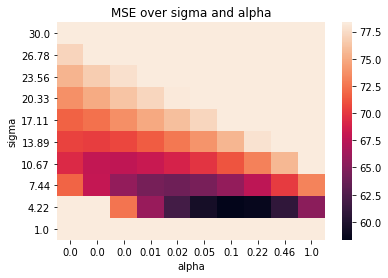

In [22]:
ax = sns.heatmap(errors, vmin=vmin, vmax=vmin+20,
                 xticklabels=errors.columns.values.round(2),
                 yticklabels=errors.index.values.round(2))
ax.set_xlabel('alpha')
ax.set_ylabel('sigma') 
ax.set_title('MSE over sigma and alpha')

plt.show()

In [23]:
sigma_range = np.linspace(1, 8, 10)
alpha_range = np.logspace(-2, -0.5, 10)
    
errors = calc_errors(sigma_range, alpha_range)

In [24]:
vmin = errors.values.min()
vmin

56.72597902047088

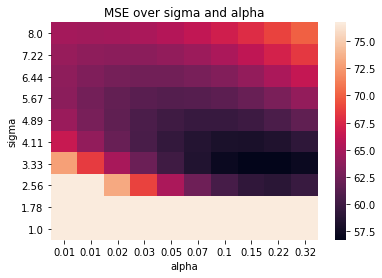

In [25]:
ax = sns.heatmap(errors, vmin=vmin, vmax=vmin+20,
                 xticklabels=errors.columns.values.round(2),
                 yticklabels=errors.index.values.round(2))
ax.set_xlabel('alpha')
ax.set_ylabel('sigma') 
ax.set_title('MSE over sigma and alpha')

plt.show()

In [26]:
sigma_range = np.linspace(2, 5, 10)
alpha_range = np.logspace(-1, -0.5, 10)
    
errors = calc_errors(sigma_range, alpha_range)

In [27]:
vmin = errors.values.min()
vmin

56.66991594567819

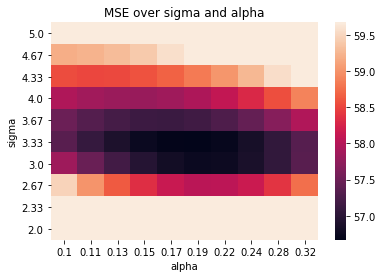

In [31]:
ax = sns.heatmap(errors, vmin=vmin, vmax=vmin+3,
                 xticklabels=errors.columns.values.round(2),
                 yticklabels=errors.index.values.round(2))
ax.set_xlabel('alpha')
ax.set_ylabel('sigma') 
ax.set_title('MSE over sigma and alpha')

plt.show()

## Duisburg

In [337]:
theta, mu, sig = train_rbf(du['dayofyear'].values, du['demand'].values, 20, 2)
yt = rbf_feat(du['dayofyear'].values, mu, sig) @ theta

In [338]:
mean_squared_error(yt, du['demand'].values)

138.51899391197605